In [1]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']




In [2]:
def make_plot_KDE(data, outfolder, figname, max_height, axis_lim, w_y, w_z, h_y, h_z, nbins=400):
    """
    Makes the gaussian kde and the y z plot.
    data is the dataframe with qx, qy, qz as headers and reach row is one sample data with the respecitve positions
    """
    lim = axis_lim
    #     print(data[pd.isnull(data).any(axis=1)])
    # save as csv
    data.to_csv(f'{outfolder}/{figname}.csv')
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#     print(zi.reshape(xi.shape))
    # plot
    fs = 24

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-lim,lim+1,1))
    plt.xticks(np.arange(-lim,lim+1,1))


    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=[0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16])
#     print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
    cbar.set_label(r'\textbf{PDF [mm$^{-2}$]}', rotation=90, fontsize=fs)
    plt.savefig(f'{outfolder}/{figname}.pdf')
    plt.savefig(f'{outfolder}/{figname}.png', dpi=600)

    plt.show()

    # query from the estimated pdf
    qry_eval = np.linspace(-lim,lim,100)
    eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
    eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

    # fit FWHM
    def gauss(x, a, x0, sigma):
        return a * np.exp(-(x-x0)**2/(2*sigma**2))


    p0 = [1, 1, 1] # Initial guess for the parameters
    # fit for parallel to x axis
    X = qry_eval
    Y = eval_x
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_x, x0_x, sigma_x = popt
    Y_fit_x = gauss(X, *popt)
    FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in x: {FWHM_x}')

    # fit for parallel to y axis
    X = qry_eval
    Y = eval_y
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_y, x0_y, sigma_y = popt
    FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in y: {FWHM_y}')
    Y_fit_y = gauss(X, *popt)
#     print(gauss(x0_y, *popt), A_y)

    # make tophat
    X = qry_eval
    Y = np.zeros(len(X))
    for idx in range(len(X)):
        if (X[idx] >= -w_y/2) & (X[idx] <= w_y/2):
            Y[idx] = h_y

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, max_height)
    # top plot
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label=r'\textbf{z=0 mm}')
#     plt.plot(qry_eval, Y_fit_x, '-.', color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot(X, Y, '-', color='darkred',linewidth=1.5, label=r'\textbf{Top-hat fit}')
    plt.plot([-w_y/2, w_y/2],[A_x/2,A_x/2], '--', color='black')
#     plt.text(-0.5, .1, f'FWHM = {FWHM_x:.2f} mm', fontsize=14)
    plt.text(-0.2, .055, r'\textbf{1.9 mm}', fontsize=16)
    
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF}' + '\n' + r'\textbf{[mm$^{-2}$]}', fontsize=fs-2)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,max_height+0.1,0.1))
    plt.xticks(np.arange(-3,3+1,1))
    leg1 = plt.legend(loc="best",  fontsize=16)
    plt.ylim(ylims)
    
    
    
    # bottom plot
    # make tophat
    X = qry_eval
    Y = np.zeros(len(X))
    for idx in range(len(X)):
        if (X[idx] >= -w_z/2+0.2) & (X[idx] <= w_z/2+0.2):
            Y[idx] = h_z
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label=r'\textbf{y=0 mm}')
    plt.plot(X, Y, '-', color='darkred',linewidth=1.5, label=r'\textbf{Top-hat fit}')
    plt.plot([-w_z/2+0.2, w_z/2+0.17],[A_x/2,A_x/2], '--', color='black')
#     plt.text(-0.5, .1, f'FWHM = {FWHM_x:.2f} mm', fontsize=14)

#     plt.text(-0.45, .15, f'FWHM = {FWHM_y:.2f} mm', fontsize=16)
    plt.text(-0.15, 0.055, r'\textbf{3.7 mm}', fontsize=16)
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF}' + '\n' + r'\textbf{[mm$^{-2}$]}', fontsize=fs-2)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.5,0.1))
    plt.xticks(np.arange(-3,3+1,1))
    leg1 = plt.legend(loc="lower left",  fontsize=16)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
    plt.savefig(f'{outfolder}/{figname}_YZ.png', dpi=900)
    plt.show()

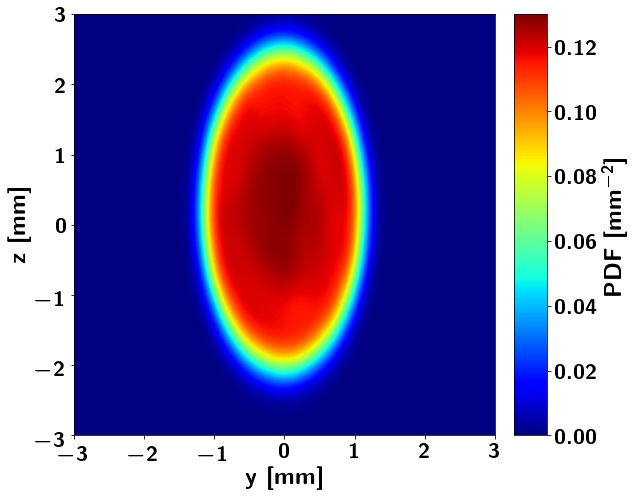

FWHM in x: 1.8853630102348433
FWHM in y: 4.010609446622631


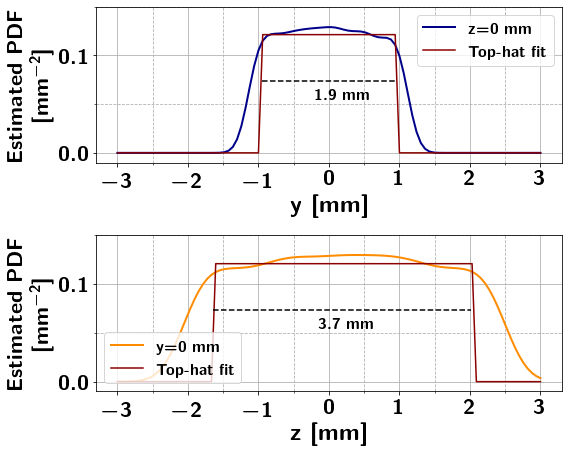

In [3]:
fname = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/012.csv_100.csv'
data = pd.read_csv(fname, index_col=0)
figname = 'distance_100cm_120kV'
outfolder = '/Users/hkromer/02_PhD/04_Publiations/01_PaperDrafts/2020/01.GenII/01.Figures/02.Design.Figure_10.COMSOL_Beam_Spot_100kV'
max_height = 0.15
axis_lim = 3
nbins = 400
w_y = 1.89
h_y = 0.12125
w_z = 3.7
h_z = 0.121
make_plot_KDE(data, outfolder, figname, max_height, axis_lim, w_y, w_z, h_y, h_z, nbins)

# 2020-09-09 Better tophat fit

In [4]:
def model(x, *p):
    """
    top hat function with three parameters that are:
    # first parameter: hat_level
    # second parameter: hat_right
    # third parameter: hat_left
    """
    hat_level, hat_right, hat_left = p
    base_level = 0

    return np.where((hat_left < x) & (x < hat_right), hat_level, base_level)

files = os.listdir('/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/')
files = [f for f in files if f.endswith('.csv')]
files = [f for f in files if 'FWHM' not in f]
files = [f for f in files if 'data' not in f]
# 010: 90 cm distance
# 011: 100 cm distance
# 012: 120 cm distance


f = '012.csv_100.csv'
data = pd.read_csv(f'/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/{f}', index_col=0)

data_tophat = pd.read_csv('/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/dataframe_tophat_fit.csv')


In [5]:
def get_pdf_along_ax(data, nbins=400, eval_points=300, lim=4):
    """
    Takes the qx, qy, qz dataset and computes the pdf using a gaussian kernel density estimator. Then there is a slice along y and z which will be returned.
    - data: qx, qy, qz dataset as a dataframe from COMSOL
    - nbins: Number of bins to interpolate for the kde between -lim and lim
    - eval_points: how many evaluation points for the pdf along an axis
    - lim: extension of the gaussian kernel estimator 
    """
    
    Y = data['qy'].values # Y axis
    Z = data['qz'].values # Z axis
    my_data = np.vstack([Y, Z])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    qry_eval = np.linspace(-lim,lim,eval_points)

    eval_Y = [k.evaluate([x,0])[0] for x in qry_eval] 
    eval_Z = [k.evaluate([0,y])[0] for y in qry_eval] 
    
    return qry_eval, eval_Y, eval_Z

In [15]:
def make_final_plot(data, data_tophat, ID=12, hv=100, max_height=0.15, nbins=400, eval_points=300, lim=4):
    """
    Make the final tophat plot
    """
    
    fs = 24
    
    
    # get the qry data
    qry_eval, eval_Y, eval_Z = get_pdf_along_ax(data, nbins, eval_points, lim)
    
    # get the tophat data
    data_tophat = data_tophat[(data_tophat['ID'] == ID) & (data_tophat['hv'] == hv)]

    hat_right_y = data_tophat['hat_right_y'].values[0]
    hat_right_z = data_tophat['hat_right_z'].values[0]
    hat_left_y = data_tophat['hat_left_y'].values[0]
    hat_left_z = data_tophat['hat_left_z'].values[0]
    hat_top_y = data_tophat['hat_top_y'].values[0]
    hat_top_z = data_tophat['hat_top_z'].values[0]
    tophat_y = data_tophat['tophat_y'].values[0]
    tophat_z = data_tophat['tophat_z'].values[0]

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, max_height)

    # Y PLOT
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_Y, color='darkblue', linewidth=2.0, label=r'\textbf{z=0 mm}')
    
    X = np.linspace(-lim,lim,1000)
    Y = model(X, hat_top_y, hat_right_y, hat_left_y)
    
    plt.plot(X, Y, '-', color='darkred',linewidth=1.5, label=r'\textbf{Top-hat fit}')
#     plt.plot([-w_y/2, w_y/2],[A_x/2,A_x/2], '--', color='black')
    tophat_y = np.round(tophat_y, 2)
    plt.text(-0.25, .055, r'\textbf{{{}}}'.format(tophat_y) + r' \textbf{mm}', fontsize=16)
    plt.plot([hat_left_y, hat_right_y], [0.05, 0.05], color='black', ls='--', lw=2)

    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF}' + '\n' + r'\textbf{[mm$^{-2}$]}', fontsize=fs-2)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,max_height+0.1,0.1))
    plt.xticks(np.arange(-3,3+1,1))
    leg1 = plt.legend(loc="upper right",  fontsize=16)
    plt.ylim(ylims)
    plt.xlim([-lim+1, lim-1])

  
    
    
    # Z PLOT
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_Z, color='darkorange', linewidth=2.0, label=r'\textbf{y=0 mm}')
    
    X = np.linspace(-lim,lim,1000)
    Y = model(X, hat_top_z, hat_right_z, hat_left_z)
    plt.plot(X, Y, '-', color='darkred',linewidth=1.5, label=r'\textbf{Top-hat fit}')

    tophat_z = np.round(tophat_z, 2)
    plt.text(-0.15, 0.055, r'\textbf{{{}}}'.format(tophat_z) + r' \textbf{mm}', fontsize=16)
    plt.plot([hat_left_z, hat_right_z], [0.05, 0.05], color='black', ls='--', lw=2)
    
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF}' + '\n' + r'\textbf{[mm$^{-2}$]}', fontsize=fs-2)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.5,0.1))
    plt.xticks(np.arange(-3,3+1,1))
    leg1 = plt.legend(loc="upper left",  fontsize=16)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.xlim([-lim+1, lim-1])
    outfolder = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_Beam_Spot_100kV/'
    figname = 'COMSOL_Beam_Spot_100kV_NEW'
    plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
    plt.savefig(f'{outfolder}/{figname}_YZ.png', dpi=900)
    plt.show()

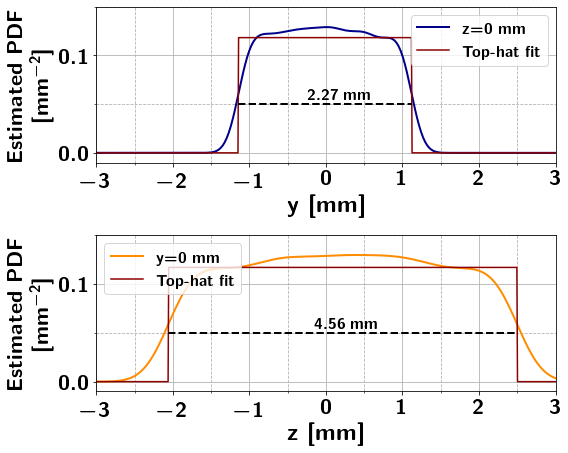

In [16]:
make_final_plot(data, data_tophat, ID=12, hv=100, max_height=0.15, nbins=400, eval_points=300, lim=4)

In [8]:
data_tophat

,ID,HV,dists,d,hv,hat_right_y,hat_right_z,hat_left_y,hat_left_z,hat_top_y,hat_top_z,tophat_y,tophat_z
0,10,60,90 cm,90.0,60.0,1.415336,2.431699,-1.410755,-2.104072,0.095492,0.095255,2.826092,4.535771
1,10,80,90 cm,90.0,80.0,1.201901,2.131002,-1.193652,-1.803106,0.130109,0.129547,2.395553,3.934108
2,10,100,90 cm,90.0,100.0,1.031656,1.905880,-1.032234,-1.569155,0.169608,0.168478,2.063890,3.475035
3,10,120,90 cm,90.0,120.0,0.912061,1.736409,-0.912048,-1.401776,0.212930,0.210653,1.824109,3.138184
4,10,140,90 cm,90.0,140.0,0.816250,1.601955,-0.813699,-1.257915,0.259681,0.256593,1.629949,2.859870
5,11,60,100 cm,100.0,60.0,1.484106,2.783759,-1.481381,-2.408834,0.079864,0.079093,2.965487,5.192593
6,11,80,100 cm,100.0,80.0,1.268025,2.468117,-1.265705,-2.085442,0.106634,0.105549,2.533730,4.553559
7,11,100,100 cm,100.0,100.0,1.111161,2.227591,-1.105164,-1.843845,0.135769,0.134348,2.216325,4.071436
8,11,120,100 cm,100.0,120.0,0.990015,2.039532,-0.982930,-1.647277,0.167438,0.166025,1.972945,3.686810
9,11,140,100 cm,100.0,140.0,0.889474,1.891565,-0.890558,-1.495609,0.202734,0.200228,1.780032,3.387173


In [12]:
d_FWHM = {}
fname = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/FWHM_data_010.csv_140.csv'
df = pd.read_csv(fname, index_col=0)
d_FWHM['010.csv'] = df

fname = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/FWHM_data_011.csv_140.csv'
df = pd.read_csv(fname, index_col=0)
d_FWHM['011.csv'] = df

fname = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/FWHM_data_012.csv_140.csv'
df = pd.read_csv(fname, index_col=0)
d_FWHM['012.csv'] = df

In [17]:
d_FWHM['010.csv'].loc[100, :]

FWHM_y    2.060201
FWHM_z    3.424749
Name: 100, dtype: float64

In [18]:
d_FWHM['011.csv'].loc[100, :]

FWHM_y    2.193980
FWHM_z    3.986622
Name: 100, dtype: float64

In [16]:
d_FWHM['012.csv'].loc[100, :]

FWHM_y    2.247492
FWHM_z    4.494983
Name: 100, dtype: float64

In [35]:
np.round(tophat_y, 2)

2.27